In [1]:
import numpy as np
import scipy as sp
from coremdlr.facies.datasets import WellLoader, FaciesDataset
from coremdlr.facies.models import FeaturePredictor, LambdaModel

Using TensorFlow backend.


In [2]:
# probably not good to get into the habit of ignorning all of the RuntimeWarnings
# but it keeps things cleaner for now

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
fdset = FaciesDataset(["205-21b-3", "204-24a-6", "204-20-6a", ],
                    test_wells=["204-19-6"],
                    features=["pseudoGR", "logs"],
                    label_resolution=32)

fdset.load_or_generate_data()

Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32, 8)), ('logs', (3842, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('pseudoGR', (13006, 32, 8)), ('logs', (13006, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3873,)), ('top', (3873,)), ('base', (3873,)), ('pseudoGR', (3873, 32, 8)), ('logs', (3873, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('pseudoGR', (1884, 32, 8)), ('logs', (1884, 11))]


In [4]:
fdset.X_train

{'pseudoGR': array([[[-1.43843855, -1.41862556, -1.44955615, ..., -0.55929281,
          -0.56834776, -0.60727161],
         [-1.45351981, -1.43362894, -1.46480887, ..., -0.55636175,
          -0.56793456, -0.60413127],
         [-1.4517765 , -1.43182138, -1.46314586, ..., -0.56730175,
          -0.57883138, -0.61474211],
         ...,
         [-1.44527454, -1.4267924 , -1.45623174, ..., -0.53281634,
          -0.54439801, -0.58637138],
         [-1.44330846, -1.42470641, -1.45431711, ..., -0.53714576,
          -0.54759023, -0.59070874],
         [-1.43988224, -1.4212563 , -1.45093795, ..., -0.54334328,
          -0.55435812, -0.59798032]],
 
        [[-1.44818228, -1.42914465, -1.45926408, ..., -0.5399333 ,
          -0.55082257, -0.59684276],
         [-1.44511088, -1.4226813 , -1.45757769, ..., -0.52046489,
          -0.53113137, -0.5692365 ],
         [-1.43321496, -1.41103996, -1.4457314 , ..., -0.53426376,
          -0.54332711, -0.58545567],
         ...,
         [-1.2904728 

In [5]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope

from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

from scipy.stats import mstats


# for balanced training and log_loss computation
train_sample_weights = compute_sample_weight('balanced', fdset.y_train)
test_sample_weights = compute_sample_weight('balanced', fdset.y_test)

# feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1', 'Chi2', 'p-val']
feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1']

def reduce_function(x):
    
    feats = []
    x = np.ma.masked_invalid(x)
    x = np.ma.masked_less_equal(x, 0.1)
    
    # central tendency
    feats.append(np.mean(x, axis=-1))
    feats.append(np.median(x, axis=-1))
    feats.append(mstats.hmean(x, axis=-1))
    feats.append(mstats.gmean(x, axis=-1))
    
    # dispersion
    feats.append(np.var(x, axis=-1))
    ideal_fourths = mstats.idealfourths(x, axis=-1)
    feats.append(ideal_fourths[:, 0])
    feats.append(ideal_fourths[:, 1])
    
    # TODO: curvature

    x_feats = np.array(feats).T
    
    return x_feats


feat_model_args = {
    # NOTE: key needs to be feature name AND feature must be specified in model_args
    'pseudoGR': {
        'model' : 'LambdaModel',
        'model_args' : {
            'feature' : 'pseudoGR',
            'lambda_fn' : reduce_function
        }
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config):
    xgb_predictor = FeaturePredictor(fdset, 
                                     model_args=model_config, 
                                     feature_model_args=feat_model_args)
    test_acc = xgb_predictor.fit(fdset, verbose=False, sample_weight=train_sample_weights)
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test), sample_weight=test_sample_weights)

In [6]:
best_params = hyperopt.fmin(
    fn=train_xgb_model,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=25
)

Training model for feature:  pseudoGR


ValueError: could not broadcast input array from shape (20721,32) into shape (20721)

In [7]:
best_params

{'colsample_bytree': 0.7528731544422103,
 'gamma': 0.27568054437399825,
 'learning_rate': 0.0231182574321478,
 'max_depth': 5.0,
 'n_estimators': 132.0,
 'reg_lambda': 7.918529466971442,
 'subsample': 0.5987222451954446}

In [8]:
params = {**XGB_SEARCH_SPACE, 
          **best_params, 
          **{'max_depth': int(best_params['max_depth']), 'n_estimators': int(best_params['n_estimators'])}}
                              
xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=feat_model_args)
xgb_predictor.fit(fdset, verbose=True)

imps = list(zip(feat_names, xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
print()
[print(pair) for pair in imps[::-1]]

Training model for feature:  pseudoGR
                      precision    recall  f1-score   support

           sandstone       0.68      0.75      0.71       934
clay-prone sandstone       0.00      0.00      0.00       307
      sandy mudstone       0.29      0.39      0.33       285
            mudstone       0.52      0.65      0.58       358

           micro avg       0.56      0.56      0.56      1884
           macro avg       0.37      0.45      0.41      1884
        weighted avg       0.48      0.56      0.51      1884

Total accuracy Score :  0.5567940552016986
Confusion Matrix: 
 [[705  13 127  89]
 [236   0  44  27]
 [ 73   0 111 101]
 [ 28   0  97 233]]

('var', 0.26502582)
('IF_0', 0.20566003)
('IF_1', 0.19358407)
('median', 0.13311209)
('mean', 0.08932522)
('gmean', 0.057245575)
('hmean', 0.056047197)


[None, None, None, None, None, None, None]

In [23]:
np.bincount(xgb_predictor.predict(fdset.X_test))

array([1042,   13,  379,  450])

In [25]:
xgb_predictor.predict_proba(fdset.X_test)

array([[0.43039837, 0.15544508, 0.10178225, 0.3123743 ],
       [0.32237685, 0.16407204, 0.21973978, 0.29381138],
       [0.33044404, 0.17821474, 0.31829658, 0.17304464],
       ...,
       [0.13131188, 0.16031705, 0.4795444 , 0.22882666],
       [0.12047436, 0.15422808, 0.42709717, 0.29820037],
       [0.3219732 , 0.14412093, 0.37131846, 0.16258742]], dtype=float32)

In [26]:
df = xgb_predictor.save_preds(fdset.test_well_names[0])
# ABOVE USES UNSCALED DATA! FIX THAT!

df['y_pred'] = xgb_predictor.predict(fdset.X_test)
df[['proba_0','proba_1','proba_2','proba_3']] = xgb_predictor.predict_proba(fdset.X_test)

In [27]:
df

,GR,RDEP,base,pseudoGR,top,y_pred,y_true,confidence,regression,proba_0,proba_1,proba_2,proba_3
0,54.628497,21.616849,2208.085920,0.608005,2208.080550,0,3,0.550943,1.414181,0.430398,0.155445,0.101782,0.312374
1,54.520250,21.632995,2208.091290,0.545559,2208.085920,0,3,0.443019,1.044907,0.322377,0.164072,0.219740,0.293811
2,54.412004,21.649140,2208.096661,0.419263,2208.091290,0,3,0.348658,1.287484,0.330444,0.178215,0.318297,0.173045
3,54.305099,21.665030,2208.102031,0.438659,2208.096661,2,3,0.648930,1.629348,0.304370,0.170331,0.362116,0.163183
4,54.313725,21.658970,2208.107401,0.446266,2208.102031,0,3,0.557620,1.525170,0.443109,0.148099,0.268183,0.140610
5,54.322351,21.652909,2208.112771,0.473391,2208.107401,0,3,0.599445,1.505100,0.362427,0.217161,0.267131,0.153281
6,54.330977,21.646848,2208.118141,0.456184,2208.112771,0,3,0.654192,1.642561,0.361212,0.175102,0.305429,0.158258
7,54.339602,21.640788,2208.123511,0.385254,2208.118141,2,3,0.336120,1.296648,0.306851,0.134561,0.370734,0.187853
8,54.348228,21.634727,2208.128881,0.444636,2208.123511,2,3,0.625902,1.608471,0.239947,0.217614,0.377756,0.164683
9,54.356854,21.628666,2208.134251,0.487099,2208.128881,0,0,0.580941,1.460293,0.372575,0.203175,0.256938,0.167312


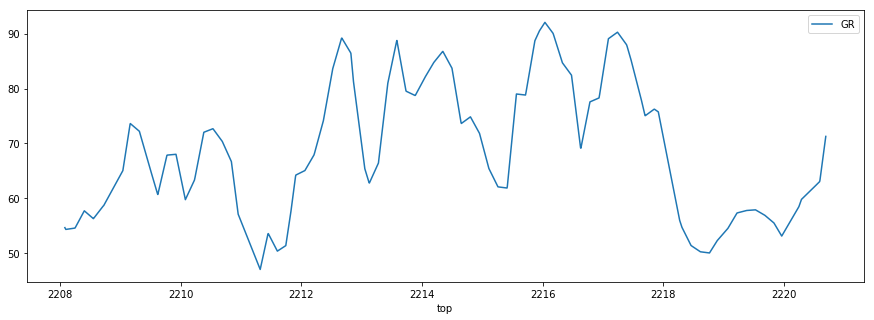

In [10]:
df.plot(x='top', y='GR', figsize=(15,5))

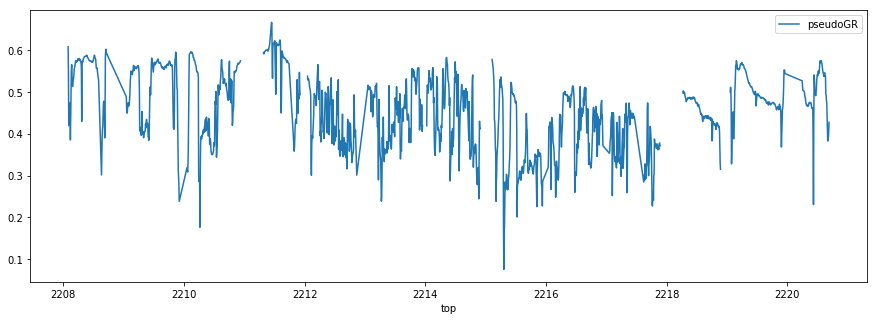

In [11]:
df.plot(x='top', y='pseudoGR', figsize=(15,5))

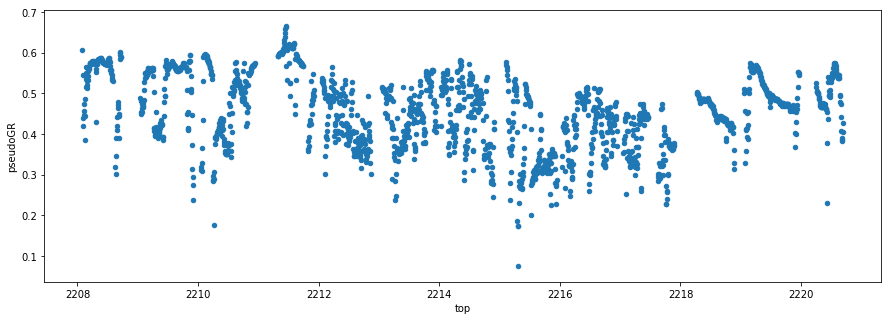

In [12]:
df.plot(x='top', y='pseudoGR', kind='scatter', figsize=(15,5))

## Thoughts

Maybe we should do a little more work on filling in or masking the pseudo gamma. It's computed from the min-max normalized image (hence the 0-1 range), but maybe we should also standardize it after computing (probably less important for XGB model, but may help quite a bit for the networks which currently have comparable performance).

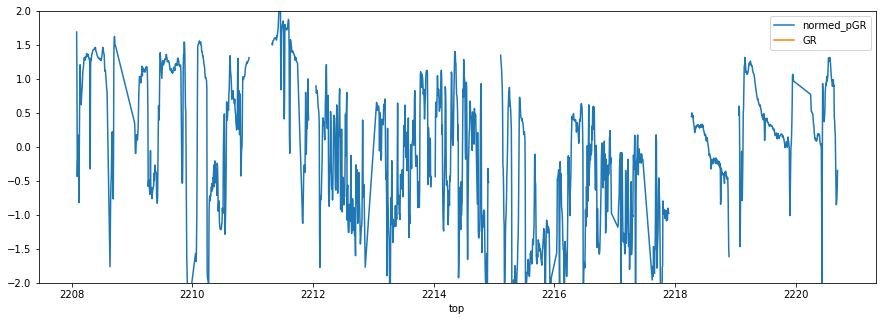

In [13]:
df['normed_pGR'] = (df.pseudoGR - df.pseudoGR.mean()) / df.pseudoGR.std()
df.plot(x='top', y=['normed_pGR','GR'], figsize=(15,5), ylim=[-2,2])

## Looking at regression estimate / error / confidence

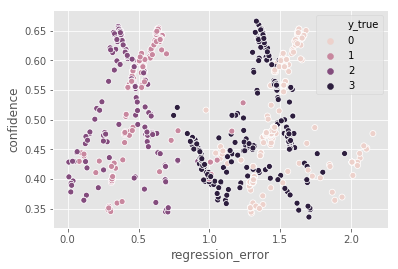

In [28]:
import seaborn as sns

df['regression_error'] = (df.regression - df.y_true.astype(float)).abs()
sns.scatterplot(x='regression_error', y='confidence', hue='y_true', data=df)

#df.plot(x='regression_error', y='confidence', kind='scatter',  figsize=(15,5))

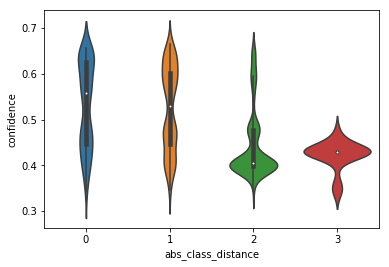

In [16]:
import seaborn as sns

df['abs_class_distance'] = (df.y_true - df.y_pred).abs()
sns.violinplot(x='abs_class_distance', y='confidence', data=df)

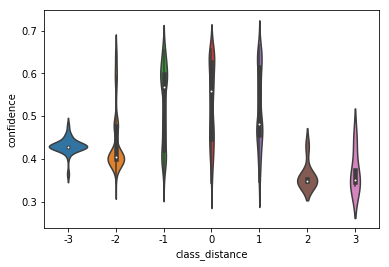

In [17]:
df['class_distance'] = (df.y_true - df.y_pred)
sns.violinplot(x='class_distance', y='confidence', data=df)

## Confusion Matrices

**NOTE**: probably going to move the analysis visualization functions into a different submodule.

In [18]:
from sklearn.metrics import confusion_matrix
from coremdlr.facies.models_utils import make_confusion_fig

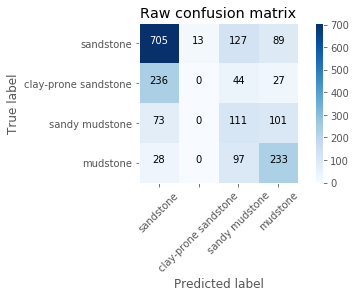

In [29]:
classes = fdset.classes
cm = confusion_matrix(df.y_true.values, df.y_pred.values)

# updated function below to have no grid by default
make_confusion_fig(cm, classes)

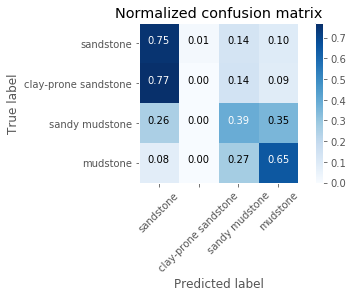

In [30]:
make_confusion_fig(cm, classes, normalize=True)
